# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [139]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import statistics
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [87]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

def hough_lines_image(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [150]:
# old version, not relevant any more
def lane_lines(hough_lines_array):
    # empty list for line parameters (m & b)
    steigung_left = []
    steigung_right = []
    achse_left = []
    achse_right = []
    
    # iterate over all line from hough line tranfsormation
    for line in hough_lines_array:
        for x1,y1,x2,y2 in line:
            
            # determine parameter for each line 
            x = [x1,x2]
            y = [y1,y2]
            steigung, achsenabschnitt = np.polyfit(x,y,1)
            
            # separate left & right lane 
            if steigung > 0:
                steigung_right.append(steigung)
                achse_right.append(achsenabschnitt)
            else:
                steigung_left.append(steigung)
                achse_left.append(achsenabschnitt)

    # take medians for line parameters 
    left_lane_steigung = statistics.median(steigung_left)
    left_lane_achsenabschnitt = statistics.median(achse_left)

    right_lane_steigung = statistics.median(steigung_right)
    right_lane_achsenabschnitt = statistics.median(achse_right)
    
    # write line parameters to lists 
    Steigung_left_list.append(left_lane_steigung)
    Achsenabschnitt_left_list.append(left_lane_achsenabschnitt)
    Steigung_right_list.append(right_lane_steigung)
    Achsenabschnitt_right_list.append(right_lane_achsenabschnitt)
    
    # smoothen of lines with based on last three frames 
    left_lane_steigung_mean = statistics.mean(Steigung_left_list[-3:])
    left_lane_achsenabschnitt_mean = statistics.mean(Achsenabschnitt_left_list[-3:])
    
    right_lane_steigung_mean = statistics.mean(Steigung_right_list[-3:])
    right_lane_achsenabschnitt_mean = statistics.mean(Achsenabschnitt_right_list[-3:])

    # extrapolate lines from bottom to end of region of interest
    left_lane = [[(540-left_lane_achsenabschnitt_mean)/left_lane_steigung_mean,540.0,(325 -left_lane_achsenabschnitt_mean)/left_lane_steigung_mean,325.0]]
    right_lane = [[(325-right_lane_achsenabschnitt_mean)/right_lane_steigung_mean,325.0,(540-right_lane_achsenabschnitt_mean)/right_lane_steigung_mean,540.0]]

    lanes = [left_lane,right_lane]
    return lanes        


## Build a Lane Finding Pipeline



In [157]:
def process_image(img):
    image_incl_lanes = img.copy()
    gray = grayscale(img)
    
    # apply Gaussian Blur on part of picture
    kernel_size = 5
    img_gauss = gaussian_blur(gray, kernel_size)
    
    # apply Canny function
    low_threshold = 50
    high_threshold = 150
    img_canny = canny(img_gauss, low_threshold, high_threshold)
    
    # black out not relevant parts of the picture
    vertices = np.array([[(50,gray.shape[0]),(450,325),(525,325),(910,gray.shape[0])]])
    img_region = region_of_interest(img_canny, vertices)
    
    # apply hough lines. returns lines as array
    rho = 1 
    theta = np.pi/180 
    hough_threshold = 15     
    min_line_len = 20 
    max_line_gap = 10

    hough_lines_array = hough_lines(img_region, rho, theta, hough_threshold, min_line_len, max_line_gap)
    
    # extrapolates line to have one full line 
    lane_lines_list = lane_lines(hough_lines_array)
    
    # draws lines on copy of original image
    draw_lines(image_incl_lanes, lane_lines_list)
    
    return image_incl_lanes
    

## Example videos
Let's try the one with the solid white lane on the right first ...



                                                        

t:  86%|████████▌ | 189/221 [47:56<00:01, 28.85it/s, now=None]

                                                        

t:   3%|▎         | 7/221 [00:00<00:03, 61.61it/s, now=None]e]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



                                                              

                                                        

t:  86%|████████▌ | 189/221 [48:03<00:01, 28.85it/s, now=None]

                                                        

t:  86%|████████▌ | 189/221 [48:03<00:01, 28.85it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.73 s, sys: 419 ms, total: 4.15 s
Wall time: 6.96 s


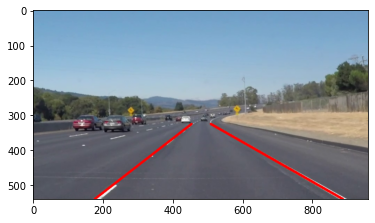

In [155]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
os.remove('test_videos_output/solidWhiteRight.mp4')
Steigung_left_list = []
Achsenabschnitt_left_list = []
Steigung_right_list = []
Achsenabschnitt_right_list = []
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [156]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!



                                                        

t:  86%|████████▌ | 189/221 [46:29<00:01, 28.85it/s, now=None]

                                                        

t:   1%|          | 5/681 [00:00<00:14, 47.64it/s, now=None]e]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



                                                              

                                                        

t:  86%|████████▌ | 189/221 [46:49<00:01, 28.85it/s, now=None]

                                                        

t:  86%|████████▌ | 189/221 [46:49<00:01, 28.85it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 12.1 s, sys: 1.24 s, total: 13.4 s
Wall time: 20.8 s


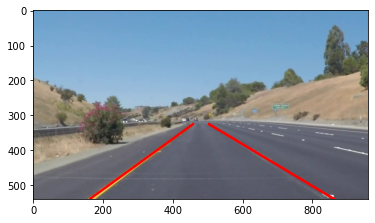

In [153]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
os.remove('test_videos_output/solidYellowLeft.mp4')
Steigung_left_list = []
Achsenabschnitt_left_list = []
Steigung_right_list = []
Achsenabschnitt_right_list = []
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [154]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [158]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)



                                                        

t:  86%|████████▌ | 189/221 [50:37<00:01, 28.85it/s, now=None]

                                                        

t:   2%|▏         | 5/251 [00:00<00:05, 47.90it/s, now=None]e]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



t:  77%|███████▋  | 194/251 [00:10<00:03, 14.80it/s, now=None]

OverflowError: signed integer is less than minimum

t:  78%|███████▊  | 195/251 [00:26<00:03, 14.80it/s, now=None]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [173]:
# save single frames of video 

import cv2
#vidcap = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
vidcap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [142]:
# other try to smoothen lines 

def lane_lines_v2(hough_lines_array):
    # define list for coordinates of points for left and right lane
    x_left = []
    x_right = []
    y_left = []
    y_right = []
    
    # iterate over all lines given by Hough Line Transformation
    for line in hough_lines_array:
        for x1,y1,x2,y2 in line:
            x = [x1,x2]
            y = [y1,y2]
            # fit line based on starting and end point
            f = np.polyfit(x,y,1)
            
            # eliminate outliers 
            if abs(f[0])>0.5 and abs(f[0])<0.8:
                if f[0] > 0:
                    for i in range(min(x),max(x)):
                        x_right.append(i)
                        y_right.append(f[0]*i+f[1])
                else:
                    for i in range(min(x),max(x)):
                        x_left.append(i)
                        y_left.append(f[0]*i+f[1])
    
    # if there were no lines or outliers read, use lane from last frame
    if len(x_left) == 0:
        x_left = x_left_list[-1]
        y_left = y_left_list[-1]
    if len(x_right) == 0:
        x_right = x_right_list[-1]
        y_left = y_right_list[-1]
    
    # append new values to full list
    x_right_list.append(x_right)
    y_right_list.append(y_right)
    x_left_list.append(x_left)
    y_left_list.append(y_left)
    
    # fit full lane to have one single lane line 
    left_lane_steigung, left_lane_achsenabschnitt = np.polyfit(x_left,y_left,1)
    right_lane_steigung, right_lane_achsenabschnitt = np.polyfit(x_right,y_right,1)
    
    # extrapolate line from bottom to about half way of the image 
    left_lane = [[(540-left_lane_achsenabschnitt)/left_lane_steigung,540.0,(330 -left_lane_achsenabschnitt)/left_lane_steigung,330.0]]
    right_lane = [[(330-right_lane_achsenabschnitt)/right_lane_steigung,330.0,(540-right_lane_achsenabschnitt)/right_lane_steigung,540.0]]

    lanes = [left_lane,right_lane]
    left_lane_list
    return lanes   